In [1]:
from google.colab import drive

In [2]:
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [18]:
ls gdrive/My\ Drive/saved

In [4]:
ls gdrive/My\ Drive/Colab\ Notebooks

dataset/  dataset.zip  __MACOSX/  Untitled0.ipynb


In [5]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import cv2
import pandas as pd
from torch.autograd import Variable

from sklearn.model_selection import train_test_split

plt.ion()   # interactive mode

In [6]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25, is_inception=False):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    if is_inception and phase == 'train':
                        # From https://discuss.pytorch.org/t/how-to-optimize-inception-model-with-auxiliary-classifiers/7958
                        outputs, aux_outputs = model(inputs)
                        loss1 = criterion(outputs, labels)
                        loss2 = criterion(aux_outputs, labels)
                        loss = loss1 + 0.4*loss2
                    else:
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))

            if phase == 'train':
              train_acc_history.append(epoch_acc)
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

In [7]:
data_dir = '/content/gdrive/My Drive/Colab Notebooks/dataset'

In [8]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    # Initialize these variables which will be set in this if statement. Each of these
    #   variables is model specific.
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet18(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "vgg":
        """ VGG11_bn
        """
        model_ft = models.vgg11_bn(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    elif model_name == "squeezenet":
        """ Squeezenet
        """
        model_ft = models.squeezenet1_0(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        model_ft.classifier[1] = nn.Conv2d(512, num_classes, kernel_size=(1,1), stride=(1,1))
        model_ft.num_classes = num_classes
        input_size = 224

    elif model_name == "densenet":
        """ Densenet
        """
        model_ft = models.densenet121(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier.in_features
        model_ft.classifier = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "inception":
        """ Inception v3
        Be careful, expects (299,299) sized images and has auxiliary output
        """
        model_ft = models.inception_v3(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        # Handle the auxilary net
        num_ftrs = model_ft.AuxLogits.fc.in_features
        model_ft.AuxLogits.fc = nn.Linear(num_ftrs, num_classes)
        # Handle the primary net
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs,num_classes)
        input_size = 299

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

In [9]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [10]:
batch_size = 64
num_classes = 2
feature_extract = True

In [11]:
model_name = "densenet"
model_densenet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


In [12]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor()
    ]),
}

print("Initializing Datasets and Dataloaders...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}

# Detect if we have a GPU available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Initializing Datasets and Dataloaders...


In [13]:
model_densenet = model_densenet.to(device)

# Gather the parameters to be optimized/updated in this run. If we are
#  finetuning we will be updating all parameters. However, if we are
#  doing feature extract method, we will only update the parameters
#  that we have just initialized, i.e. the parameters with requires_grad
#  is True.
params_to_update = model_densenet.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_densenet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_densenet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

Params to learn:
	 classifier.weight
	 classifier.bias


In [14]:
criterion = nn.CrossEntropyLoss()
num_epochs = 25

In [15]:
model_densenet, train_hist_dense, val_hist_dense = train_model(model_densenet, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))


Epoch 0/24
----------
train Loss: 0.6671 Acc: 0.5939
val Loss: 0.7047 Acc: 0.5405

Epoch 1/24
----------
train Loss: 0.5261 Acc: 0.7469
val Loss: 0.6317 Acc: 0.6032

Epoch 2/24
----------
train Loss: 0.4948 Acc: 0.7695
val Loss: 0.5827 Acc: 0.6822

Epoch 3/24
----------
train Loss: 0.4850 Acc: 0.7690
val Loss: 0.5726 Acc: 0.6862

Epoch 4/24
----------
train Loss: 0.4665 Acc: 0.7816
val Loss: 0.5551 Acc: 0.7004

Epoch 5/24
----------
train Loss: 0.4436 Acc: 0.7911
val Loss: 0.5087 Acc: 0.7470

Epoch 6/24
----------
train Loss: 0.4239 Acc: 0.8133
val Loss: 0.4941 Acc: 0.7551

Epoch 7/24
----------
train Loss: 0.4288 Acc: 0.8108
val Loss: 0.4858 Acc: 0.7611

Epoch 8/24
----------
train Loss: 0.4187 Acc: 0.8158
val Loss: 0.4789 Acc: 0.7672

Epoch 9/24
----------
train Loss: 0.4292 Acc: 0.8128
val Loss: 0.5269 Acc: 0.7186

Epoch 10/24
----------
train Loss: 0.4535 Acc: 0.7876
val Loss: 0.4597 Acc: 0.7915

Epoch 11/24
----------
train Loss: 0.4079 Acc: 0.8098
val Loss: 0.4525 Acc: 0.7874

Ep

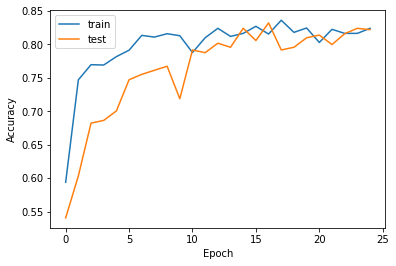

In [24]:
import matplotlib.pyplot as plt

fig = plt.figure()
# summarize history for accuracy
plt.plot(train_hist_dense)
plt.plot(val_hist_dense)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#fig.savefig("saved/AallStocks.png", bbox_inches='tight')
#fig.savefig("gdrive/My\ Drive/saved/densenet.svg", format='svg', dpi=1200)
images_dir = '/content/gdrive/My Drive/saved'
fig.savefig(f"{images_dir}/densenet.svg", format='svg', dpi=1200)

In [ ]:
train_hist_dense

In [25]:
model_name = "resnet"
model_resnet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [26]:
model_resnet = model_resnet.to(device)

params_to_update = model_resnet.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_resnet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_resnet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

model_resnet, train_hist_resnet, val_hist_resnet = train_model(model_resnet, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Params to learn:
	 fc.weight
	 fc.bias
Epoch 0/24
----------
train Loss: 0.6280 Acc: 0.6527
val Loss: 0.5980 Acc: 0.6336

Epoch 1/24
----------
train Loss: 0.5343 Acc: 0.7343
val Loss: 0.5372 Acc: 0.7166

Epoch 2/24
----------
train Loss: 0.4938 Acc: 0.7685
val Loss: 0.5566 Acc: 0.7328

Epoch 3/24
----------
train Loss: 0.4780 Acc: 0.7771
val Loss: 0.5552 Acc: 0.6761

Epoch 4/24
----------
train Loss: 0.4729 Acc: 0.7705
val Loss: 0.5199 Acc: 0.7510

Epoch 5/24
----------
train Loss: 0.4701 Acc: 0.7836
val Loss: 0.5247 Acc: 0.7045

Epoch 6/24
----------
train Loss: 0.4448 Acc: 0.7952
val Loss: 0.4940 Acc: 0.7713

Epoch 7/24
----------
train Loss: 0.4555 Acc: 0.7932
val Loss: 0.4966 Acc: 0.7449

Epoch 8/24
----------
train Loss: 0.4496 Acc: 0.7977
val Loss: 0.4827 Acc: 0.7611

Epoch 9/24
----------
train Loss: 0.4385 Acc: 0.8057
val Loss: 0.4800 Acc: 0.7733

Epoch 10/24
----------
train Loss: 0.4626 Acc: 0.7871
val Loss: 0.5129 Acc: 0.7652

Epoch 11/24
----------
train Loss: 0.4294 Acc: 

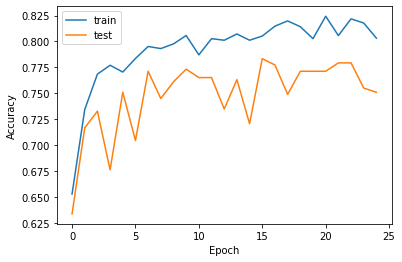

In [27]:
fig = plt.figure()
# summarize history for accuracy
plt.plot(train_hist_resnet)
plt.plot(val_hist_resnet)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

images_dir = '/content/gdrive/My Drive/saved'
fig.savefig(f"{images_dir}/resnetnet.svg", format='svg', dpi=1200)

In [28]:
model_name = "alexnet"
model_alexnet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_alexnet = model_alexnet.to(device)

params_to_update = model_alexnet.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_alexnet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_alexnet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

model_alexnet, train_hist_alexnet, val_hist_alexnet = train_model(model_alexnet, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-4df8aa71.pth



Params to learn:
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/24
----------
train Loss: 0.5674 Acc: 0.6920
val Loss: 0.9143 Acc: 0.6113

Epoch 1/24
----------
train Loss: 0.5412 Acc: 0.7403
val Loss: 0.7296 Acc: 0.6316

Epoch 2/24
----------
train Loss: 0.5522 Acc: 0.7408
val Loss: 0.6695 Acc: 0.6437

Epoch 3/24
----------
train Loss: 0.5283 Acc: 0.7499
val Loss: 0.8125 Acc: 0.6356

Epoch 4/24
----------
train Loss: 0.5342 Acc: 0.7499
val Loss: 0.7749 Acc: 0.6397

Epoch 5/24
----------
train Loss: 0.5280 Acc: 0.7554
val Loss: 0.7934 Acc: 0.6437

Epoch 6/24
----------
train Loss: 0.4769 Acc: 0.7901
val Loss: 0.6737 Acc: 0.6680

Epoch 7/24
----------
train Loss: 0.5000 Acc: 0.7579
val Loss: 0.7795 Acc: 0.6741

Epoch 8/24
----------
train Loss: 0.4876 Acc: 0.7705
val Loss: 0.8657 Acc: 0.6194

Epoch 9/24
----------
train Loss: 0.5669 Acc: 0.7589
val Loss: 1.1089 Acc: 0.6093

Epoch 10/24
----------
train Loss: 0.6934 Acc: 0.7071
val Loss: 0.9874 Acc: 0.6579

Epoch 11/24
----------
tra

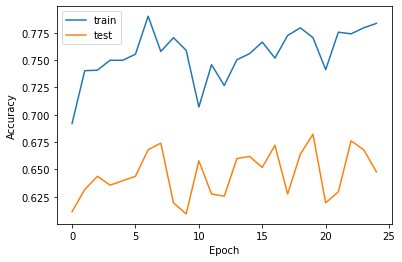

In [29]:
fig = plt.figure()
# summarize history for accuracy
plt.plot(train_hist_alexnet)
plt.plot(val_hist_alexnet)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

images_dir = '/content/gdrive/My Drive/saved'
fig.savefig(f"{images_dir}/alexnet.svg", format='svg', dpi=1200)

In [30]:
model_name = "vgg"
model_vgg, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_vgg = model_vgg.to(device)

params_to_update = model_vgg.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_vgg.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_vgg.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

model_vgg, train_hist_vgg, val_hist_vgg = train_model(model_vgg, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Downloading: "https://download.pytorch.org/models/vgg11_bn-6002323d.pth" to /root/.cache/torch/hub/checkpoints/vgg11_bn-6002323d.pth



Params to learn:
	 classifier.6.weight
	 classifier.6.bias
Epoch 0/24
----------
train Loss: 0.6142 Acc: 0.6608
val Loss: 0.5274 Acc: 0.7692

Epoch 1/24
----------
train Loss: 0.5094 Acc: 0.7564
val Loss: 0.5147 Acc: 0.7348

Epoch 2/24
----------
train Loss: 0.4842 Acc: 0.7745
val Loss: 0.4999 Acc: 0.7551

Epoch 3/24
----------
train Loss: 0.4679 Acc: 0.7725
val Loss: 0.4481 Acc: 0.7955

Epoch 4/24
----------
train Loss: 0.4416 Acc: 0.8113
val Loss: 0.4261 Acc: 0.8077

Epoch 5/24
----------
train Loss: 0.4640 Acc: 0.7806
val Loss: 0.4266 Acc: 0.7955

Epoch 6/24
----------
train Loss: 0.4571 Acc: 0.7826
val Loss: 0.4113 Acc: 0.8077

Epoch 7/24
----------
train Loss: 0.4398 Acc: 0.7846
val Loss: 0.4037 Acc: 0.8239

Epoch 8/24
----------
train Loss: 0.4417 Acc: 0.7876
val Loss: 0.4077 Acc: 0.8138

Epoch 9/24
----------
train Loss: 0.4537 Acc: 0.7836
val Loss: 0.4362 Acc: 0.7955

Epoch 10/24
----------
train Loss: 0.4403 Acc: 0.7947
val Loss: 0.3947 Acc: 0.8300

Epoch 11/24
----------
tra

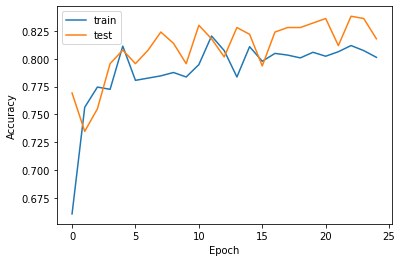

In [31]:
fig = plt.figure()
# summarize history for accuracy
plt.plot(train_hist_vgg)
plt.plot(val_hist_vgg)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

images_dir = '/content/gdrive/My Drive/saved'
fig.savefig(f"{images_dir}/vgg.svg", format='svg', dpi=1200)

In [32]:
model_name = "squeezenet"
model_squeezenet, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

model_squeezenet = model_squeezenet.to(device)

params_to_update = model_squeezenet.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_squeezenet.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_squeezenet.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

model_squeezenet, train_hist_squeezenet, val_hist_squeezenet = train_model(model_squeezenet, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Downloading: "https://download.pytorch.org/models/squeezenet1_0-a815701f.pth" to /root/.cache/torch/hub/checkpoints/squeezenet1_0-a815701f.pth



Params to learn:
	 classifier.1.weight
	 classifier.1.bias
Epoch 0/24
----------
train Loss: 0.6216 Acc: 0.6492
val Loss: 0.8103 Acc: 0.5121

Epoch 1/24
----------
train Loss: 0.5271 Acc: 0.7378
val Loss: 0.7496 Acc: 0.5526

Epoch 2/24
----------
train Loss: 0.4987 Acc: 0.7645
val Loss: 0.8280 Acc: 0.6012

Epoch 3/24
----------
train Loss: 0.4707 Acc: 0.7801
val Loss: 0.7091 Acc: 0.5870

Epoch 4/24
----------
train Loss: 0.4905 Acc: 0.7755
val Loss: 0.6331 Acc: 0.6113

Epoch 5/24
----------
train Loss: 0.4659 Acc: 0.7861
val Loss: 0.7506 Acc: 0.6215

Epoch 6/24
----------
train Loss: 0.4567 Acc: 0.7886
val Loss: 0.6940 Acc: 0.6417

Epoch 7/24
----------
train Loss: 0.4500 Acc: 0.8002
val Loss: 0.7227 Acc: 0.6316

Epoch 8/24
----------
train Loss: 0.4424 Acc: 0.8078
val Loss: 0.6336 Acc: 0.6356

Epoch 9/24
----------
train Loss: 0.4627 Acc: 0.7856
val Loss: 0.6347 Acc: 0.6255

Epoch 10/24
----------
train Loss: 0.4263 Acc: 0.8158
val Loss: 0.6521 Acc: 0.6397

Epoch 11/24
----------
tra

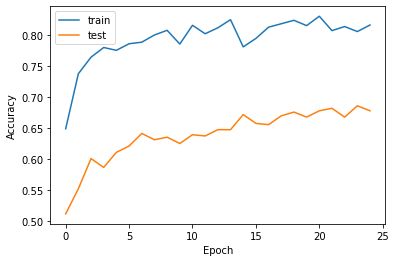

In [33]:
fig = plt.figure()
# summarize history for accuracy
plt.plot(train_hist_squeezenet)
plt.plot(val_hist_squeezenet)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

images_dir = '/content/gdrive/My Drive/saved'
fig.savefig(f"{images_dir}/squeezenet.svg", format='svg', dpi=1200)

In [34]:
model_name = "inception"
model_inception, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor()
    ]),
}

print("Initializing New Datasets and Dataloaders for Inception ...")

# Create training and validation datasets
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
# Create training and validation dataloaders
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'val']}


model_inception = model_inception.to(device)

params_to_update = model_inception.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_inception.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_inception.named_parameters():
        if param.requires_grad == True:
            print("\t",name)
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(params_to_update, lr=0.001, momentum=0.9)

model_inception, train_hist_inception, val_hist_inception = train_model(model_inception, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs, is_inception=(model_name=="inception"))

Downloading: "https://download.pytorch.org/models/inception_v3_google-1a9a5a14.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-1a9a5a14.pth



Initializing New Datasets and Dataloaders for Inception ...
Params to learn:
	 AuxLogits.fc.weight
	 AuxLogits.fc.bias
	 fc.weight
	 fc.bias
Epoch 0/24
----------
train Loss: 0.9552 Acc: 0.5455
val Loss: 0.6353 Acc: 0.6599

Epoch 1/24
----------
train Loss: 0.8420 Acc: 0.6744
val Loss: 0.5733 Acc: 0.7510

Epoch 2/24
----------
train Loss: 0.7647 Acc: 0.7242
val Loss: 0.5508 Acc: 0.7247

Epoch 3/24
----------
train Loss: 0.7379 Acc: 0.7383
val Loss: 0.5185 Acc: 0.7510

Epoch 4/24
----------
train Loss: 0.7101 Acc: 0.7524
val Loss: 0.5050 Acc: 0.7692

Epoch 5/24
----------
train Loss: 0.6919 Acc: 0.7504
val Loss: 0.4818 Acc: 0.8057

Epoch 6/24
----------
train Loss: 0.6957 Acc: 0.7609
val Loss: 0.4905 Acc: 0.7773

Epoch 7/24
----------
train Loss: 0.6898 Acc: 0.7614
val Loss: 0.4904 Acc: 0.7773

Epoch 8/24
----------
train Loss: 0.6904 Acc: 0.7609
val Loss: 0.4804 Acc: 0.7794

Epoch 9/24
----------
train Loss: 0.6764 Acc: 0.7645
val Loss: 0.4653 Acc: 0.7895

Epoch 10/24
----------
train

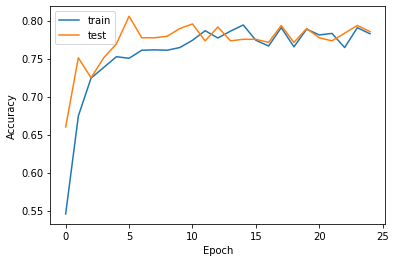

In [35]:
fig = plt.figure()
# summarize history for accuracy
plt.plot(train_hist_inception)
plt.plot(val_hist_inception)
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

images_dir = '/content/gdrive/My Drive/saved'
fig.savefig(f"{images_dir}/inception.svg", format='svg', dpi=1200)